In [216]:
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import sys
import argparse
import glob
import time
import re

import caffe


%matplotlib inline

## 関数群

In [274]:
def predict(img_path):
    # Make classifier.
    pycaffe_dir = os.path.dirname("..")
    model_def =os.path.join(pycaffe_dir,
                "../examples/mnist/lenet.prototxt")
    pretrained_model = os.path.join(pycaffe_dir,
                "../examples/mnist/lenet_iter_10000.caffemodel")
    classifier = caffe.Classifier(model_def, pretrained_model)

    input_file = img_path

#     print("Loading file: %s" % input_file)
    grayimg = caffe.io.load_image(input_file, color=False)[:,:,0]
    inputs = [np.reshape(grayimg, (28, 28, 1))]

#     print("Classifying %d inputs." % len(inputs))

    # Classify.
    start = time.time()
    predictions = classifier.predict(inputs)
    return predictions

def bar_plot(input_path=None,ax=None):
    rel = predict(input_path)[0]
    ax = ax.bar(np.arange(0,10),rel,tick_label= np.arange(0,10))
    plt.ylabel("Probability")
    return ax

def prev_data(input_path):
    im = Image.open(input_path)
    plt.imshow(np.asarray(im),cmap='gray')
    
def plot_both(input_path):
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(121)
    prev_data(input_path)    
    ax2 = fig.add_subplot(122)
    bar_plot(input_path,ax2)
    plt.tight_layout()


モデルは、SGDを使って10000回ループを回したLenetを使っている。このモデルのテストデータでのaccuracyは95%程で、Lossは0.3程であった。以下で行う分類は、学習に利用されたデータも入っているため、注意が必要である。分析の最終的な目的が重なったデータへの検知であるため、データ作成に非線形な処理がかかることを想定し、簡便な条件にした。

## mnistデータへのモデルの予測結果

Loading file: ../data/mnist/jpg/00000000_7.jpg
Classifying 1 inputs.
Loading file: ../data/mnist/jpg/00000005_1.jpg
Classifying 1 inputs.


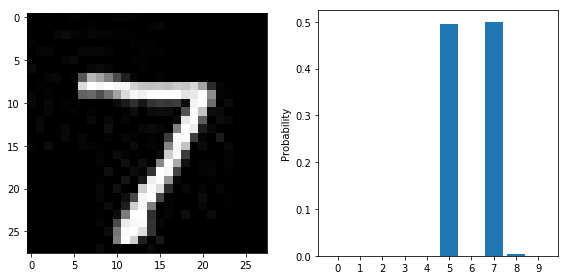

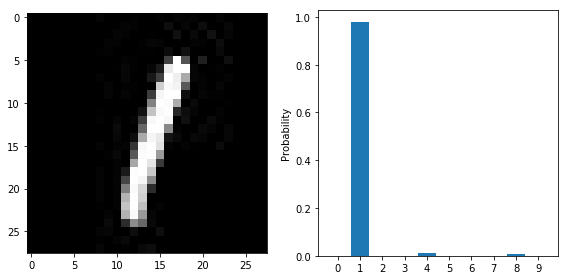

In [215]:
sample_image = "../data/mnist/jpg/00000000_7.jpg"
sample_image2 = "../data/mnist/jpg/00000005_1.jpg"
plot_both(sample_image)
plot_both(sample_image2)

上のグラフは左側に認識の対象となる図をプロットしている。右側には、学習したモデルによって与えられた画像が何に分類されるかを確率で表示している。<br> １つ目の例では正解は"7"であり、右側の確率では"7"への分類が最も確率が高く、ある程度正しく分類されていることがわかる。

# データを二枚重ねた場合の予測

## データ作成

二枚のデータを足して二で割ったものと、二枚のデータを足してものの二種のデータの作成を試した。

In [307]:
def simple_override(p1,p2):
    rel = (np.asarray(Image.open(p1)) + np.asarray(Image.open(p2)))/2
    return rel

def simple_override_add(p1,p2):
    rel = (np.asarray(Image.open(p1)) + np.asarray(Image.open(p2)))
    return rel


### 足して似で割る

In [320]:
base_dir = "../data/mnist/jpg/"
save_path = "../data/mnist/jpg/simple_overrides/"
for _,_, files in os.walk(base_dir):
    lists = files[:100]
#     print(files)
#     break
    for i,f1 in enumerate(lists):
        if len(f1.split("_"))==4:
            continue
        for j,f2 in enumerate(lists):
            if len(f1.split("_"))==4:
                continue
            a1 = re.split('\.|_',f1)
            a2 = re.split('\.|_',f2)
            path = a1[0] + "_" + a2[0] +"_"+a1[1]+"_" + a2[1]+".jpg"
            out_path = save_path + path
            rel = simple_override(base_dir+f1,base_dir+f2)
            im = Image.fromarray(rel)
            im.save(out_path)
        if i%10 == 0:
            print("{}% done...".format(i/len(files)))
            break


0% done...


### 足すのみ

In [321]:
base_dir = "../data/mnist/jpg/"
save_path = "../data/mnist/jpg/simple_overrides_add/"
for _,_, files in os.walk(base_dir):
    lists = files[:100]
#     print(files)
#     break
    for i,f1 in enumerate(lists):
        if len(f1.split("_"))==4:
            continue
        for j,f2 in enumerate(lists):
            if len(f1.split("_"))==4:
                continue
            a1 = re.split('\.|_',f1)
            a2 = re.split('\.|_',f2)
            path = a1[0] + "_" + a2[0] +"_"+a1[1]+"_" + a2[1]+".jpg"
            out_path = save_path + path
            rel = simple_override_add(base_dir+f1,base_dir+f2)
            im = Image.fromarray(rel)
            im.save(out_path)
        if i%10 == 0:
            print("{}% done...".format(i/len(files)))
            break


0% done...


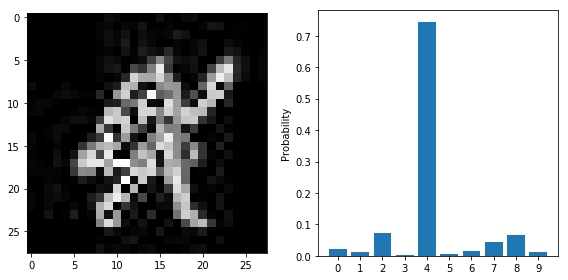

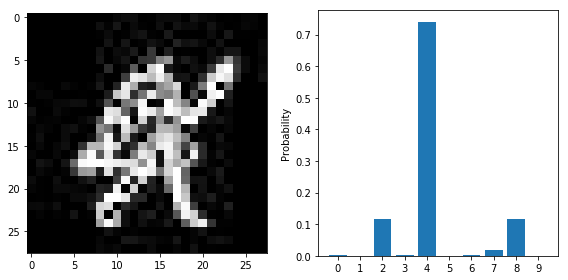

In [322]:
plot_both("../data/mnist/jpg/simple_overrides/00008276_00000125_4_9.jpg")
plot_both("../data/mnist/jpg/simple_overrides_add/00008276_00000125_4_9.jpg")

どちらも同じデータを使って、データの作成を行っている。上側のデータは足した後、二で割ったものである。下側のデータは足したままのものである。下側の方が鮮明に文字がわかり、予測もはっきりとした数値が出ているのがわかる。また、現実に使うとしても下側のデータの方が頻繁に遭遇するため、単純に合算する方法が優れている。

In [323]:
def double_predict(path):
    probs = predict(path)[0]
    p1 = np.argmax(probs)
    probs[p1] = 0
    p2 = np.argmax(probs)
    path = re.split("/",path)[-1]
    path = re.split("_|\.",path)
    return [set([int(path[2]),int(path[3])]),set([p1,p2])]

def score_full(rel_list):
    print('label:{}  predict:{}'.format(rel_list[0],rel_list[1]))
    if len(rel_list[0]) == 1:
        if rel_list[0] in rel_list[1]:
            return 1
        else:
            return 0
    if(rel_list[0] == rel_list[1]):
        return 1
    else:
        return 0

def score_fifty(rel_list):
    print('label:{}  predict:{}'.format(rel_list[0],rel_list[1]))
    if len(rel_list[0]) == 1:
        if (list(rel_list[0])[0] in rel_list[1]):
            return 1
        else:
            return 0
    if (list(rel_list[0])[0] in rel_list[1]) | (list(rel_list[0])[1] in rel_list[1]):
        return 1
    else:
        return 0
    
def accuracy(path_list,opt="strict"):
    if opt == "strict":
        rel =0.0;
        for path in path_list:
            rel+=score_full(double_predict(path))
        return rel/len(path_list)
    elif opt == "easy":
        rel =0.0;
        for path in path_list:
            rel+=score_fifty(double_predict(path))
        return rel/len(path_list)

# 正解率

## 足して２で割ったデータセットのサンプル

In [324]:
base_dir = "../data/mnist/jpg/simple_overrides/"
for dirs,_,files in os.walk(base_dir):
    files = list(map(lambda x:dirs+x,lists))
    acc_strict = accuracy(files,opt="strict")
    acc_easy = accuracy(files,opt="easy")
    print('comprete accuracy :{:.5f}'.format(acc_strict))
    print('partial accuracy :{:.3f}'.format(acc_easy))

label:set([3, 4])  predict:set([0, 6])
label:set([4, 6])  predict:set([4, 6])
label:set([0, 4])  predict:set([8, 0])
label:set([4, 6])  predict:set([4, 6])
label:set([1, 4])  predict:set([4, 6])
label:set([4])  predict:set([8, 4])
label:set([3, 4])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 6])
label:set([0, 4])  predict:set([8, 0])
label:set([4, 5])  predict:set([0, 4])
label:set([3, 4])  predict:set([8, 6])
label:set([1, 4])  predict:set([8, 4])
label:set([4])  predict:set([8, 4])
label:set([8, 4])  predict:set([8, 0])
label:set([3, 4])  predict:set([8, 4])
label:set([4, 6])  predict:set([4, 6])
label:set([0, 4])  predict:set([8, 0])
label:set([0, 4])  predict:set([8, 4])
label:set([4, 6])  predict:set([8, 4])
label:set([4])  predict:set([4, 6])
label:set([8, 4])  predict:set([8, 7])
label:set([9, 4])  predict:set([4, 7])
label:set([2, 4])  predict:set([2, 6])
label:set([8, 4])  predict:set([8, 4])
label:set([2, 4])  predict:set([8, 4])
label:set([0, 4])  predict:set([8,

100のサンプルデータでは、完全一致の正解率は17%であり、予測の１つでもあっている正解率は88%である。

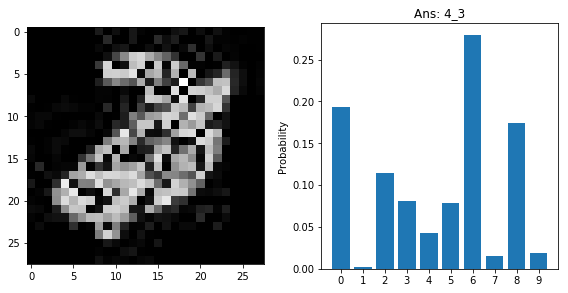

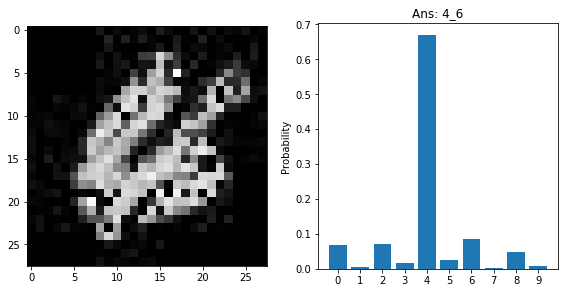

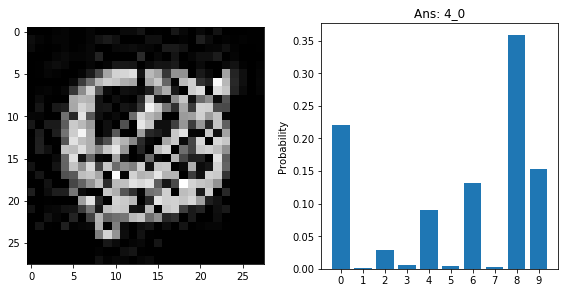

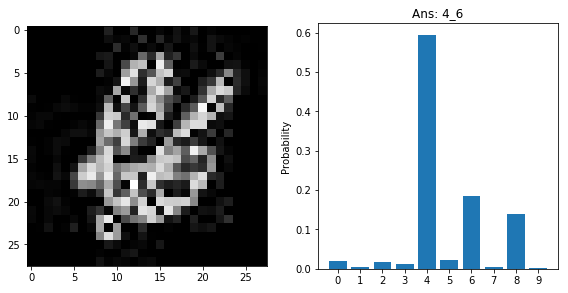

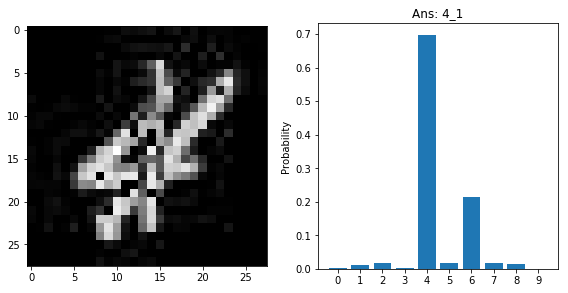

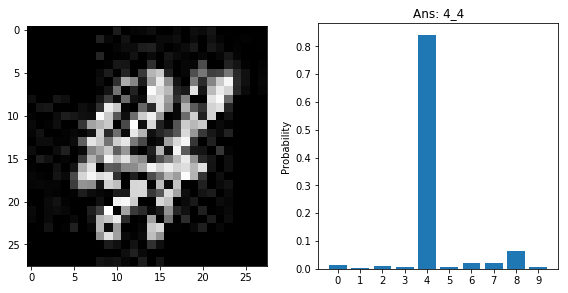

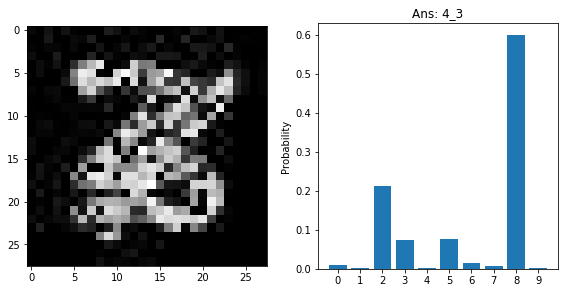

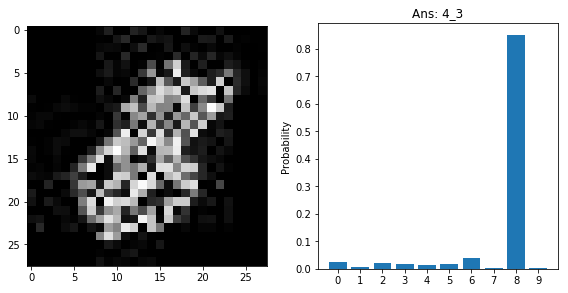

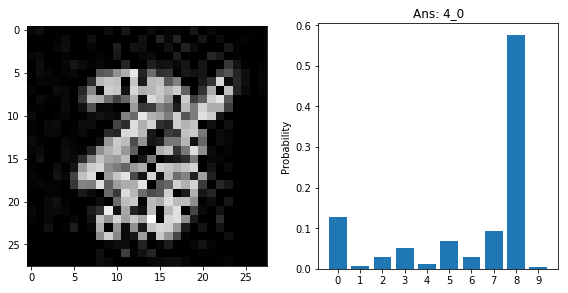

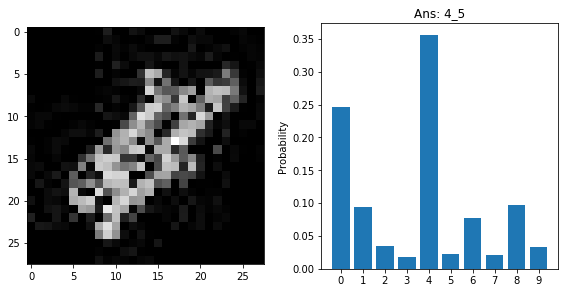

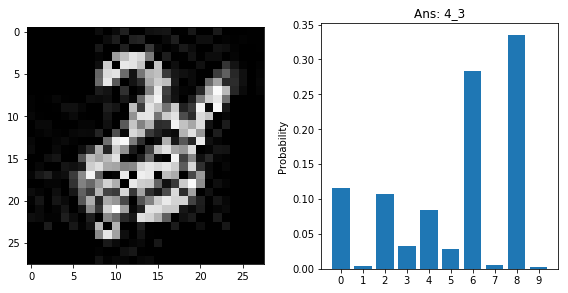

In [325]:
base_dir = "../data/mnist/jpg/simple_overrides/"
for dirs,_,files in os.walk(base_dir):
    for i,file in enumerate(files):
        plot_both(base_dir +file)
        title = re.split("_|\.",file)
        title = "Ans: "+title[2] + "_" + title[3]
        plt.title(title)
        if(i==10):
            break

上図は、左側が予測に使われる画像であり、右側が予測結果である。右側のグラフのタイトルには、ラベルの正解が何であったかが記載されている。

## 単純に合算したデータセットのサンプル

In [326]:
base_dir = "../data/mnist/jpg/simple_overrides_add//"
for dirs,_,files in os.walk(base_dir):
    files = list(map(lambda x:dirs+x,lists))
    acc_strict = accuracy(files,opt="strict")
    acc_easy = accuracy(files,opt="easy")
    print('comprete accuracy :{:.5f}'.format(acc_strict))
    print('partial accuracy :{:.3f}'.format(acc_easy))

label:set([3, 4])  predict:set([3, 6])
label:set([4, 6])  predict:set([2, 4])
label:set([0, 4])  predict:set([8, 0])
label:set([4, 6])  predict:set([8, 4])
label:set([1, 4])  predict:set([4, 6])
label:set([4])  predict:set([8, 4])
label:set([3, 4])  predict:set([8, 2])
label:set([3, 4])  predict:set([8, 3])
label:set([0, 4])  predict:set([8, 3])
label:set([4, 5])  predict:set([8, 4])
label:set([3, 4])  predict:set([8, 2])
label:set([1, 4])  predict:set([8, 4])
label:set([4])  predict:set([8, 4])
label:set([8, 4])  predict:set([8, 3])
label:set([3, 4])  predict:set([8, 0])
label:set([4, 6])  predict:set([4, 6])
label:set([0, 4])  predict:set([8, 3])
label:set([0, 4])  predict:set([8, 4])
label:set([4, 6])  predict:set([8, 4])
label:set([4])  predict:set([4, 6])
label:set([8, 4])  predict:set([8, 3])
label:set([9, 4])  predict:set([8, 4])
label:set([2, 4])  predict:set([2, 6])
label:set([8, 4])  predict:set([8, 3])
label:set([2, 4])  predict:set([8, 4])
label:set([0, 4])  predict:set([8,

100のサンプルデータでは、完全一致の正解率は8%であり、予測の１つでもあっている正解率は83%である。

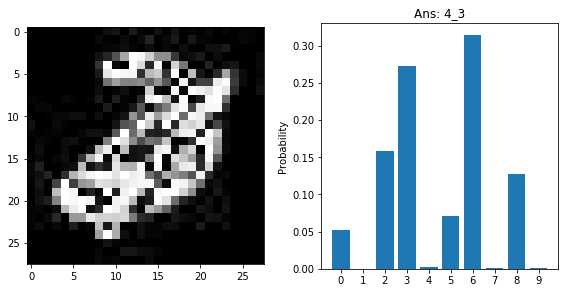

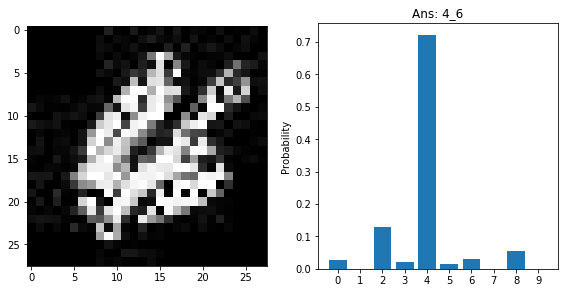

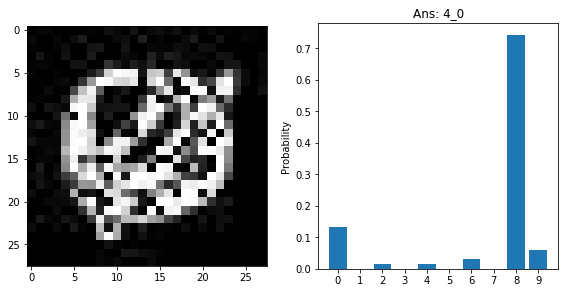

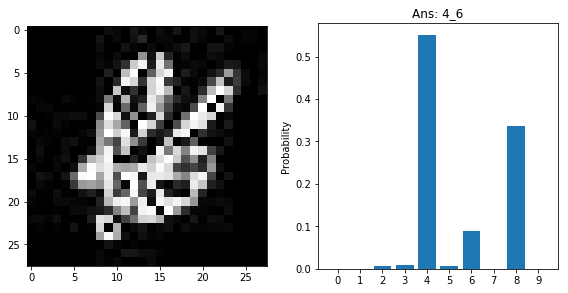

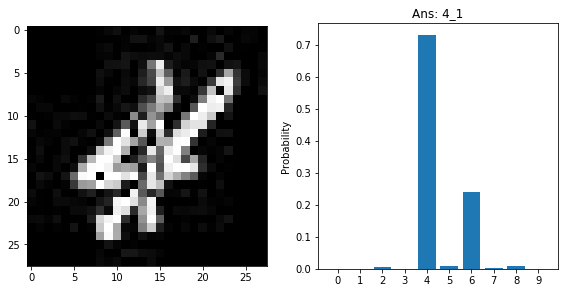

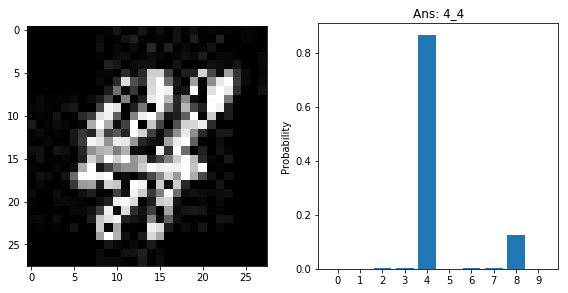

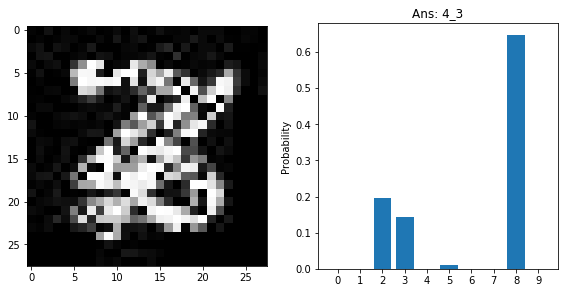

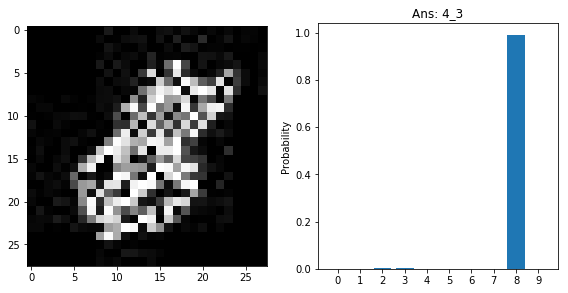

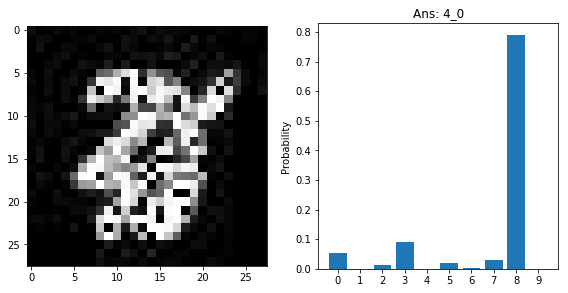

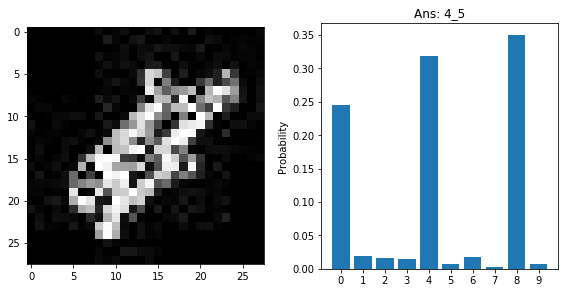

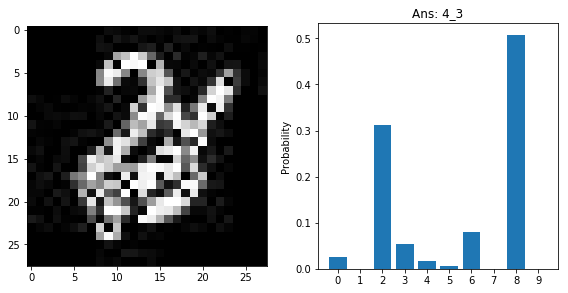

In [327]:
base_dir = "../data/mnist/jpg/simple_overrides_add/"
for dirs,_,files in os.walk(base_dir):
    for i,file in enumerate(files):
        plot_both(base_dir +file)
        title = re.split("_|\.",file)
        title = "Ans: "+title[2] + "_" + title[3]
        plt.title(title)
        if(i==10):
            break

### まとめ

２つのデータの作成方法では、サンプルデータ100枚で試した限りでは、2つのデータを足して２で割ったもののほうが、単純に合計したものの方よりも優れた結果になることがわかった。これは、グラフを見てわかるように、ぼやけたデータへの予測のほうが、はっきりとした輪郭を持つデータへの予測を完全に間違えるよりも正解率が高く出るということである。<br>
今回は画像の認識という作業から発展させたため、このようなモデルを使ったが、物体検知モデルのほうがより現実に即した解を与えると推測される。今後の解析では、物体検知モデルではSDDやYOLOなどを使うつもりである。